# 1.0 Data Wrangling

## Foundations of Spatial Data Science - CASA0013

### Group Project - Policy Brief

In [14]:
#Importing required packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

## 1.1 Calculating Rate of Professional AirBnB hosts by LSOA

### 1.1.1 Read in data

In [28]:
# Reading in listings data
listings = gpd.read_feather("data/2022-09-10-listings.geofeather")

In [29]:
#Reading in the Lower Super Output Area (LSOA) shapefile
lsoa = gpd.read_file("data/boundaries/LSOA_2004_London_Low_Resolution.shp")

### 1.1.2 Identify professional listings

In [30]:
#Converting the total_listing_count column to numpy array for manipulation
host_count = np.array(listings['host_total_listings_count'].values.tolist())

In [31]:
host_count[host_count > 1] = 0 #Changing any values above 1 to 0. Meaning "not casual" (professional).

In [32]:
listings['casual'] = host_count #Creating a new column which identifies if a listings host is casual (1 listing), or professional (>1 listing)



|  | Professional | Non-Professional (Casual)|
| --- | --- | --- |
| **Listing Count** | > 1 |1 |

### 1.1.3 Convert to same CRS

In [33]:
#LSOA is in the British National Grid (BNG) coordinate reference system.
listings = listings.to_crs(lsoa.crs)

### 1.1.4 Spatial Join listings to LSOAs (spatial aggregation unit)

In [34]:
#Spatially joining the LSOA to each listing
lsoa_ls = listings.sjoin(lsoa, predicate="within")

In [35]:
#Number of professional vs casual Airbnb hosts by LSOA
lsoa_ls["count"] = 1
professinal_count = lsoa_ls.groupby(["LSOA_CODE", "casual"])["count"].sum().reset_index()

In [36]:
host_lsoa = professinal_count.groupby("LSOA_CODE")["count"].sum().reset_index() #Total number of hosts per LSOA

In [37]:
#Identifying hosts that are professional (more than one listing)
prop_count = professinal_count[professinal_count["casual"] ==0].rename(columns={"count":"professional_count"}).merge(host_lsoa.rename(columns={"count":"total_count"}), on="LSOA_CODE", how="right")

In [38]:
#Calculating the proportion of professional AirBnB hosts to total hosts per LSOA
prop_count["prop"] = prop_count["professional_count"] / prop_count["total_count"]

In [39]:
#Merging this proportion with the overall spatially referenced LSOA data
lsoa_prop = lsoa.merge(prop_count, how="left", on="LSOA_CODE")

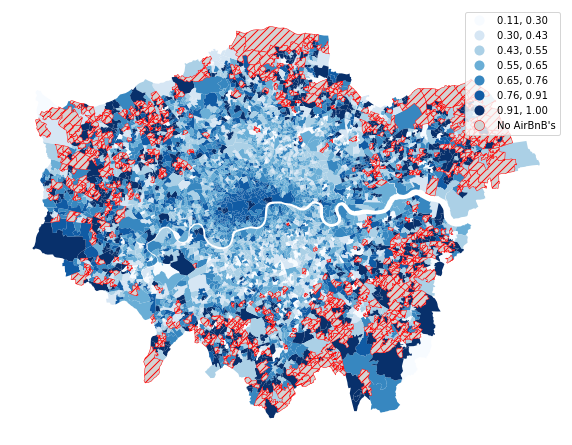

In [40]:
#An inital map identifying rates of professionalisation of AirBnB across London
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_prop.plot(column="prop", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues",
               missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5))

plt.axis("off")

plt.savefig("figures/proportion_of_professional_hosts.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

## 1.2 Gentrification Classifications (Yee and Dennett, 2020)

In [ ]:
#Import data

## 1.3 Cultural Infrastructure
### 1.3.1 Read in data

In [22]:
#Import data
cultural = pd.read_csv('data/cultural-infrastructure-map-all-sites.csv')
print(f'Rows, Columns = {cultural.shape}')

#Clean column name
cultural.rename(columns = {'Cultural Venue Type':'venue_type'}, 
                   inplace = True)

print(cultural.dtypes)
cultural.head(5)

Rows, Columns = (10003, 29)
BOROUGH                     object
venue_type                  object
additional_contact_name     object
address1                    object
address2                    object
address3                    object
alternativenames           float64
borough_code                object
borough_name                object
building_name               object
contact_name                object
easting                    float64
fid_london_ward            float64
greenflagcommunityaward    float64
gss_code                    object
latitude                   float64
longitude                  float64
northing                   float64
os_addressbase_uprn        float64
rm_organisation_name        object
runtime                     object
site_name                   object
ward                        object
ward_2018_code              object
ward_2018_name              object
ward_code                   object
ward_code_2018              object
ward_name_2018             

,BOROUGH,venue_type,additional_contact_name,address1,address2,address3,alternativenames,borough_code,borough_name,building_name,...,rm_organisation_name,runtime,site_name,ward,ward_2018_code,ward_2018_name,ward_code,ward_code_2018,ward_name_2018,website
0,Tower Hamlets,Archives,NaN,Thomson Reuters,30 South Colonnade,Canary Wharf,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Reuters Archive,NaN,E05009323,Canary Wharf,NaN,NaN,NaN,https://reuters.screenocean.com/
1,Tower Hamlets,Archives,NaN,Whitechapel High Street,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Whitechapel Art Gallery,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.whitechapelgallery.org/
2,Tower Hamlets,Archives,NaN,37 Spital Square,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Society for the Protection of Ancient Buildings,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,https://www.spab.org.uk/
3,Tower Hamlets,Archives,NaN,Watson House,54 Baker Street,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Lasa,NaN,E05009333,Spitalfields & Banglatown,NaN,NaN,NaN,http://www.lasa.org.uk/
4,Tower Hamlets,Archives,NaN,Graces Alley,NaN,NaN,NaN,E09000030,Tower Hamlets,NaN,...,NaN,04/20/2020,Wilton's Music Hall,NaN,E05009336,Whitechapel,NaN,NaN,NaN,https://www.wiltons.org.uk/


In [42]:
#Convert to spatial object (geopandas)
gdf_cultural = gpd.GeoDataFrame(cultural, 
      geometry=gpd.points_from_xy(cultural.longitude, cultural.latitude, crs='epsg:4326'))

# Reproject to British National Grid
gdf_cultural = gdf_cultural.to_crs(lsoa.crs)

In [26]:
#List of venue types
gdf_cultural.venue_type.unique()

array(['Archives', 'Artists workspaces', 'Arts centres', 'Cinemas',
       'Commercial galleries', 'Community centres',
       'Creative co-working desk space', 'Creative workspaces',
       'Dance performance venues', 'Dance rehearsal studios',
       'Fashion and design', 'Jewellery design',
       'Large media production studios', 'Legal street art walls',
       'LGBT+ night time venues', 'Libraries',
       "Live in artists' workspace", 'Makerspaces',
       'Making and manufacturing', 'Museums and public galleries',
       'Music (office based businesses)', 'Music recording studios',
       'Music rehearsal studios', 'Music venues (all)',
       'Music venues (grassroots)', 'Outdoor spaces for cultural use',
       'Prop and costume making', 'Pubs', 'Set and exhibition building',
       'Skate Parks', 'Textile design', 'Theatre rehearsal studio',
       'Theatres'], dtype=object)

### 1.3.2 Join points to LSOAs

In [50]:
#Spatially joining the LSOA to each cultural point
gdf_cultural = gdf_cultural.sjoin(lsoa, predicate="within")

gdf_cultural["count"] = 1

In [59]:
#Summarise by LSOA
count_by_lsoa = gdf_cultural.groupby('LSOA_CODE')['count'].sum().reset_index()

#**Need to calculate rate by LSOA area OR population...


In [58]:
count_by_lsoa.head(5)

,LSOA_CODE,count
0,E01000001,12
1,E01000002,26
2,E01000003,4
3,E01000004,275
4,E01000005,22


In [60]:
#Merge sum per LSOA back with the overall spatially referenced LSOA data
lsoa_clt = lsoa.merge(count_by_lsoa, how="left", on="LSOA_CODE")

(500655.06033394457, 564875.8132172046, 154258.35576021337, 203156.24388533537)

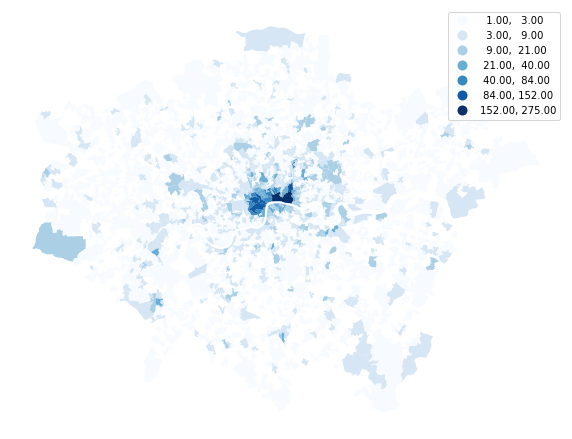

In [62]:
#An inital map identifying rates of professionalisation of AirBnB across London
fig, ax = plt.subplots(1, figsize=(10,10))

lsoa_clt.plot(column="count", legend=True, ax=ax, k=7, scheme = "fisher_jenks", cmap="Blues"
              # , missing_kwds= dict(color = "lightgrey", label="No AirBnB's", edgecolor = "red", hatch= "///", linewidth=0.5)
             )

plt.axis("off")

# plt.savefig("figures/proportion_of_professional_hosts.png", dpi=300, facecolor="white", bbox_inches="tight")
# plt.show()